数据集汇总
- CIFAR-10
- MNIST
- Symbolic Fitting

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

cifar_path = './CIFAR10'
mnist_path = './mnist'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### CIFAR-10

100.0%


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


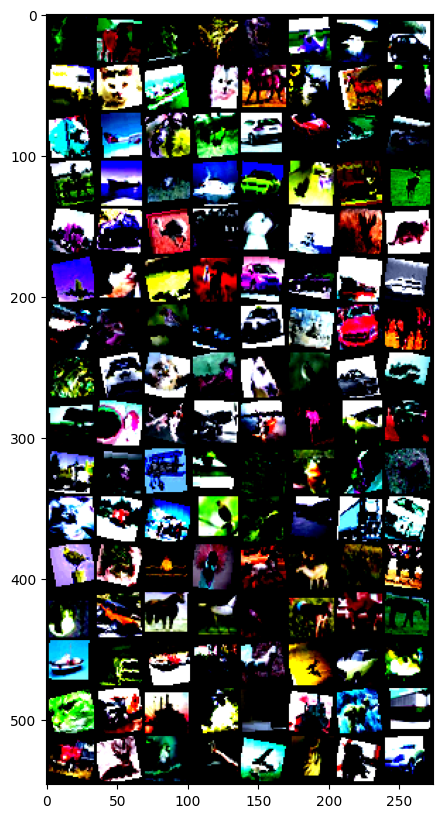

 bird horse horse  frog
Images shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


In [ ]:
# 定义数据预处理和变换，增加更多数据增强操作
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪，带有填充
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
    transforms.RandomRotation(15),  # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 下载并加载CIFAR-10训练集和测试集
trainset = torchvision.datasets.CIFAR10(root=cifar_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=cifar_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# ======================================== 演示 =============================================

# CIFAR-10类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 打印部分数据
def imshow(img):
    # img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # 调整图像显示的大小
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一些随机的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# 打印图像和标签的维度
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

### MNIST

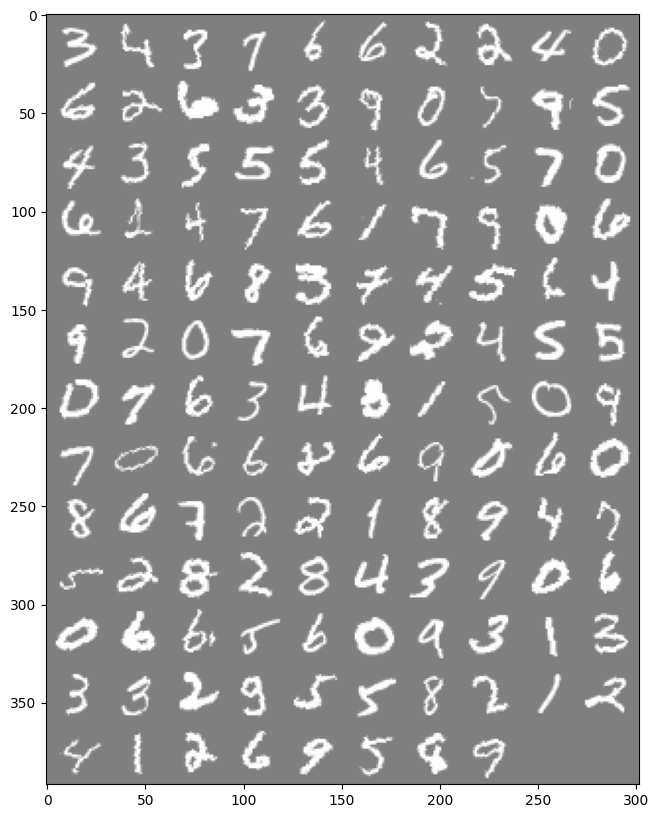

    3     4     3     7     6     6     2     2     4     0
Images shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


In [3]:
# 定义数据预处理和变换
transform = transforms.Compose([
    transforms.RandomRotation(15),  # 随机旋转
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化，MNIST 是单通道数据，均值和标准差为单个值
])


trainset = torchvision.datasets.MNIST(root=mnist_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root=mnist_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# ======================================== 演示 =============================================

# MNIST类别标签（0-9数字）
classes = tuple(str(i) for i in range(10))

# 打印部分数据
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # 调整图像显示的大小
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# 获取一些随机的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图像
imshow(torchvision.utils.make_grid(images, nrow=10, padding=2, normalize=True))  # 每行10个图像
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))
# 打印图像和标签的维度
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

### Symbolic Fitting

该数据集由KAN本身提供，通过生成随机数据，然后使用KAN进行拟合，得到拟合结果。

In [3]:
def create_dataset(f, 
                   n_var=2, 
                   f_mode = 'col',
                   ranges = [-1,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)
        
    
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
                
    if f_mode == 'col':
        train_label = f(train_input)
        test_label = f(test_input)
    elif f_mode == 'row':
        train_label = f(train_input.T)
        test_label = f(test_input.T)
    else:
        print(f'f_mode {f_mode} not recognized')
        
    # if has only 1 dimension
    if len(train_label.shape) == 1:
        train_label = train_label.unsqueeze(dim=1)
        test_label = test_label.unsqueeze(dim=1)
        
    def normalize(data, mean, std):
            return (data-mean)/std
            
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

# ======================================== 演示 =============================================
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))